Estratégia: https://www.projectpro.io/article/speech-emotion-recognition-project-using-machine-learning/573#mcetoc_1i4jlb94qo

Dataset: https://www.kaggle.com/datasets/uwrfkaggler/ravdess-emotional-speech-audio

# Using CNN-LSTM

### Imports

In [ ]:
import os
from glob import glob
import pickle
import itertools
import matplotlib.pyplot as plt
from PIL import Image
import IPython
from IPython.display import Audio
import pandas as pd

import numpy as np
from scipy.stats import zscore
from sklearn.model_selection import train_test_split
import librosa

DATASET_PATH = '../dataset/ravdess-emotional-speech-audio' # Change this to your dataset path

### Labels

In [2]:
# Código exatamente como na imagem (provavelmente com erro de slicing)
# RAVDESS Database #ignore CALM
label_dict_ravdess = {'02': 'NEU', '03': 'HAP', '04': 'SAD', '05': 'ANG', '06': 'FEA', '07': 'DIS', '08': 'SUR'}

def set_label_ravdess(audio_file, gender):
    label = label_dict_ravdess.get(audio_file[6:-16])
    if gender == True:
        if int(audio_file[18:-4]) % 2 == 0:
            label = 'f_' + label
        if int(audio_file[18:-4]) % 2 == 1:
            label = 'm_' + label
    return label

In [ ]:
file_path = DATASET_PATH
file_names = os.listdir(file_path)

signal = []
labels = []

sample_rate = 16000
max_pad_len = 49100 # 3 seconds worth of audio

for actor_folder in file_names:
    for audio_index, audio_file in enumerate(os.listdir(os.path.join(file_path, actor_folder))):
        if audio_file[6:-16] in list(label_dict_ravdess.keys()):
            # Librosa read audio file
            y, sr = librosa.core.load(os.path.join(file_path, actor_folder, audio_file),
                                      sr=sample_rate, offset=0.5)
            
            # Normalization
            y = zscore(y)
            # Padding
            if len(y) < max_pad_len:
                y_padded = np.zeros(max_pad_len)
                y_padded[:len(y)] = y
                y = y_padded
            elif len(y) > max_pad_len:
                y = np.asarray(y[:max_pad_len])

            signal.append(y)
            labels.append(set_label_ravdess(audio_file, False))
            
labels = np.asarray(labels).ravel()

print(f"Number of audio files imported: {labels.shape[0]}")

Number of audio files imported: 1344


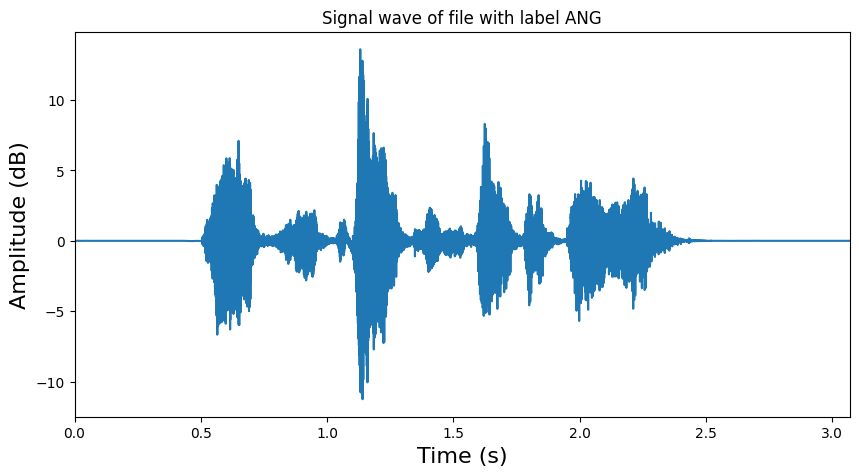

Audio file 'ANG':


In [4]:
# Select one random audio file
random_idx = np.random.randint(len(labels))
random_label = labels[random_idx]
random_signal = signal[random_idx]

# Plot signal wave
plt.figure(figsize=(10,5))
plt.plot(np.arange(len(random_signal))/float(sample_rate), random_signal)
plt.xlim((np.arange(len(random_signal))/float(sample_rate))[0], (np.arange(len(random_signal))/float(sample_rate))[-1])
plt.ylabel('Amplitude (dB)', fontsize=16)
plt.xlabel('Time (s)', fontsize=16)
plt.title(f'Signal wave of file with label {random_label}')
plt.show()

# Play audio file
print(f"Audio file '{random_label}':")
Audio(random_signal, rate=sample_rate)

In [5]:
# Number of augmented data
nb_augmented = 2

# Function to add noise to a signals with a desired Signal Noise ratio (SNR)
def noisy_signal(signal, snr_low=15, snr_high=30, nb_augmented=2):

    signal_len = len(signal)
    noise = np.random.normal(size=(nb_augmented, signal_len))

    # Compute signal and noise power
    s_power = np.sum((signal / (2.0 ** 15)) ** 2) / signal_len
    n_power = np.sum((noise / (2.0 ** 15)) ** 2, axis=1) / signal_len
    snr = np.random.randint(snr_low, snr_high)

    # Compute K coeff for each noise
    K = np.sqrt(s_power / n_power * 10 ** (- snr / 10))
    K = np.ones((signal_len, nb_augmented)) * K

    return signal + K.T * noise

augmented_signal = list(map(noisy_signal, signal))

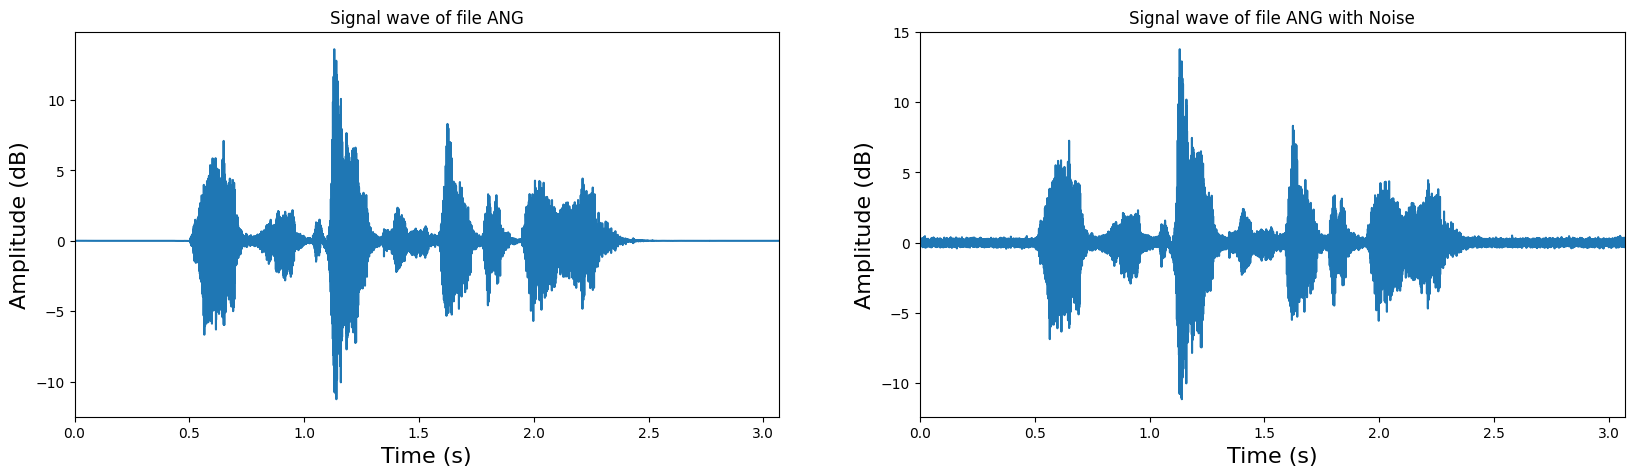

Audio file 'ANG':


Audio file 'ANG' with noise:


In [6]:
# Plot signal wave
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.plot(np.arange(len(random_signal))/float(sample_rate), random_signal)
plt.xlim((np.arange(len(random_signal))/float(sample_rate))[0], (np.arange(len(random_signal))/float(sample_rate))[-1])
plt.xlabel('Time (s)', fontsize=16)
plt.ylabel('Amplitude (dB)', fontsize=16)
plt.title(f'Signal wave of file {random_label}')

# Plot signal wave with noise
plt.subplot(1,2,2)
plt.plot(np.arange(len(random_signal))/float(sample_rate), augmented_signal[random_idx][0])
plt.xlim((np.arange(len(random_signal))/float(sample_rate))[0], (np.arange(len(random_signal))/float(sample_rate))[-1])
plt.xlabel('Time (s)', fontsize=16)
plt.ylabel('Amplitude (dB)', fontsize=16)
plt.title(f'Signal wave of file {random_label} with Noise')
plt.show()

# Play audio file
print(f"Audio file '{random_label}':")
IPython.display.display(Audio(random_signal, rate=sample_rate))

# Play same audio file with noise
print(f"Audio file '{random_label}' with noise:")
IPython.display.display(Audio(augmented_signal[random_idx][0], rate=sample_rate))

In [7]:
def mel_spectrogram(y, sr=16000, n_fft=512, win_length=256,
                    hop_length=128, window='hamming', n_mels=128, fmax=4000):

    # Compute Mel spectrogram
    mel_feat = np.abs(librosa.stft(y, n_fft=n_fft, window=window,
                                   win_length=win_length, hop_length=hop_length)) ** 2

    mel_feat = librosa.feature.melspectrogram(S=mel_feat, sr=sr, n_mels=n_mels, fmax=fmax)

    mel_feat = librosa.power_to_db(mel_feat, ref=np.max)

    return mel_feat

# add noise to the audio signals in "signal"
augmented_signal = list(map(noisy_signal, signal))

# get the Mel spectrogram for all the audio
mel_spect = np.asarray(list(map(mel_spectrogram, signal)))
noisy_mel_spect = [np.asarray(list(map(mel_spectrogram, augmented_signal[i])))
                   for i in range(len(augmented_signal))]

In [8]:
# train test split for both datasets and combine them into one augmented set
org_mel_spec_train, org_mel_spec_test, noisy_mel_spec_train, noisy_mel_spec_test, label_train, label_test = \
train_test_split(mel_spect, noisy_mel_spect, labels, test_size=0.2)

aug_label_train = np.asarray(list(itertools.chain.from_iterable([[label] * nb_augmented for label in label_train])))
noisy_mel_spec_train = np.asarray(list(itertools.chain.from_iterable(noisy_mel_spec_train)))

X_train = np.concatenate((org_mel_spec_train, noisy_mel_spec_train))
y_train = np.concatenate((label_train, aug_label_train))

X_test = org_mel_spec_test
y_test = label_test

# Delete
del org_mel_spec_train, noisy_mel_spec_train, label_train, aug_label_train, noisy_mel_spec_test, org_mel_spec_test, label_test
del mel_spect, noisy_mel_spect, labels

In [9]:
# Create Time distributed data for LSTM
window_size = 128
gap = 64

def frame(x, step_size, window):
    n_frames = 1 + int((x.shape[2] - window) / step_size)
    frames = np.zeros((x.shape[0], n_frames, x.shape[1], window)).astype(np.float32)
    for t in range(n_frames):
        frames[:,t,:,:] = np.copy(x[:, :, (t*step_size):(t*step_size + window)]).astype(np.float32)
    return frames

X_train = frame(X_train, gap, window_size)
X_test = frame(X_test, gap, window_size)

In [10]:
# Save Train and test set
# Create directory if it doesn't exist
os.makedirs('multimodal_data', exist_ok=True)
pickle.dump(X_train.astype(np.float16), open('multimodal_data/[RAVDESS][MEL_SPECT][X_train].pkl', 'wb'))
pickle.dump(y_train, open('multimodal_data/[RAVDESS][MEL_SPECT][y_train].pkl', 'wb'))
pickle.dump(X_test.astype(np.float16), open('multimodal_data/[RAVDESS][MEL_SPECT][X_test].pkl', 'wb'))
pickle.dump(y_test, open('multimodal_data/[RAVDESS][MEL_SPECT][y_test].pkl', 'wb'))

## Building the model

In [24]:
import os
from glob import glob
import pickle
import numpy as np
from IPython.display import Image
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Dropout, Activation, TimeDistributed
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import LSTM, BatchNormalization, Flatten
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from sklearn.preprocessing import LabelEncoder

In [15]:
# Data loading

X_train = pickle.load(open('multimodal_data/[RAVDESS][MEL_SPECT][X_train].pkl', 'rb'))
y_train = pickle.load(open('multimodal_data/[RAVDESS][MEL_SPECT][y_train].pkl', 'rb'))
y_test = pickle.load(open('multimodal_data/[RAVDESS][MEL_SPECT][y_test].pkl', 'rb'))
X_test = pickle.load(open('multimodal_data/[RAVDESS][MEL_SPECT][X_test].pkl', 'rb'))

In [16]:
y_train

array(['ANG', 'NEU', 'NEU', ..., 'ANG', 'ANG', 'ANG'],
      shape=(3225,), dtype='<U3')

In [26]:
lb = LabelEncoder()
label_dict_ravdess = {'02': 'NEU', '03': 'HAP', '04': 'SAD', '05': 'ANG', '06': 'FEA', '07': 'DIS', '08': 'SUR'}
label_array_ravdess = np.array(list(label_dict_ravdess.values()))
to_categorical(lb.fit_transform(np.ravel(label_array_ravdess)))

array([[0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1.]])

In [13]:
lb = LabelEncoder()
y_train = to_categorical(lb.fit_transform(np.ravel(y_train)))
y_test = to_categorical(lb.transform(np.ravel(y_test)))

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], X_train.shape[3], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], X_test.shape[3], 1)

In [5]:
input_y = Input(shape=X_train.shape[1:], name='Input')

# CNN 64
y = TimeDistributed(Conv2D(64, kernel_size=(3, 3), strides=(1, 1), padding='same'),
                    name='Conv_1')(input_y)
y = TimeDistributed(BatchNormalization(), name='BatchNorm_1')(y)
y = TimeDistributed(Activation('elu'), name='Activ_1')(y)
y = TimeDistributed(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'),
                    name='MaxPool_1')(y)
y = TimeDistributed(Dropout(0.2), name='Drop_1')(y)

# CNN 64
y = TimeDistributed(Conv2D(64, kernel_size=(3, 3), strides=(1, 1), padding='same'),
                    name='Conv_2')(y)
y = TimeDistributed(BatchNormalization(), name='BatchNorm_2')(y)
y = TimeDistributed(Activation('elu'), name='Activ_2')(y)
y = TimeDistributed(MaxPooling2D(pool_size=(4, 4), strides=(4, 4), padding='same'),
                    name='MaxPool_2')(y)
y = TimeDistributed(Dropout(0.1), name='Drop_2')(y)

# CNN 128
y = TimeDistributed(Conv2D(128, kernel_size=(3, 3), strides=(1, 1), padding='same'),
                    name='Conv_3')(y)
y = TimeDistributed(BatchNormalization(), name='BatchNorm_3')(y)
y = TimeDistributed(Activation('elu'), name='Activ_3')(y)
y = TimeDistributed(MaxPooling2D(pool_size=(4, 4), strides=(4, 4), padding='same'),
                    name='MaxPool_3')(y)
y = TimeDistributed(Dropout(0.1), name='Drop_3')(y)

# Second CNN 128
y = TimeDistributed(Conv2D(128, kernel_size=(3, 3), strides=(1, 1), padding='same'),
                    name='Conv_4')(y)
y = TimeDistributed(BatchNormalization(), name='BatchNorm_4')(y)
y = TimeDistributed(Activation('elu'), name='Activ_4')(y)
y = TimeDistributed(MaxPooling2D(pool_size=(4, 4), strides=(4, 4), padding='same'),
                    name='MaxPool_4')(y)
y = TimeDistributed(Dropout(0.2), name='Drop_4')(y)

# Flatten
y = TimeDistributed(Flatten(), name='Flat')(y)

# LSTM part
y = LSTM(256, return_sequences=False, dropout=0.2, name='LSTM_1')(y)
y = Dense(y_train.shape[1], activation='softmax', name='FC')(y)

model = Model(inputs=input_y, outputs=y)

model.summary()

I0000 00:00:1761920675.096185   88164 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4164 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 6GB Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 5, 128, 128, 1) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv_1 (TimeDistributed)        │ (None, 5, 128, 128,    │           640 │
│                                 │ 64)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BatchNorm_1 (TimeDistributed)   │ (None, 5, 128, 128,    │           256 │
│                                 │ 64)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Activ_1 (TimeDistributed)       │ (None, 5, 128, 128,    │             0 │
│                                 │ 64)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MaxPool_1 (TimeDistributed)     │ (None, 5, 64, 64, 64)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Drop_1 (TimeDistributed)        │ (None, 5, 64, 64, 64)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv_2 (TimeDistributed)        │ (None, 5, 64, 64, 64)  │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BatchNorm_2 (TimeDistributed)   │ (None, 5, 64, 64, 64)  │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Activ_2 (TimeDistributed)       │ (None, 5, 64, 64, 64)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MaxPool_2 (TimeDistributed)     │ (None, 5, 16, 16, 64)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Drop_2 (TimeDistributed)        │ (None, 5, 16, 16, 64)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv_3 (TimeDistributed)        │ (None, 5, 16, 16, 128) │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BatchNorm_3 (TimeDistributed)   │ (None, 5, 16, 16, 128) │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Activ_3 (TimeDistributed)       │ (None, 5, 16, 16, 128) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MaxPool_3 (TimeDistributed)     │ (None, 5, 4, 4, 128)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Drop_3 (TimeDistributed)        │ (None, 5, 4, 4, 128)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv_4 (TimeDistributed)        │ (None, 5, 4, 4, 128)   │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BatchNorm_4 (TimeDistributed)   │ (None, 5, 4, 4, 128)   │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Activ_4 (TimeDistributed)       │ (None, 5, 4, 4, 128)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MaxPool_4 (TimeDistributed)     │ (None, 5, 1, 1, 128)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Drop_4 (TimeDistributed)        │ (None, 5, 1, 1, 128)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Flat (TimeDistributed)          │ (None, 5, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_1 (LSTM)                   │ (None, 256)            │       394,240 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 656,583 (2.50 MB)

 Trainable params: 655,815 (2.50 MB)

 Non-trainable params: 768 (3.00 KB)

## Training and testing

In [10]:
from tensorflow.keras.optimizers import schedules

# Define decay schedule to approximate reaching 1e-6
lr_schedule = schedules.ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=100000, # Number of steps to decay
    decay_rate=0.99, # Adjust this value based on decay behavior
    staircase=True
)

model.compile(optimizer=SGD(learning_rate=lr_schedule, momentum=0.8),
              loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_accuracy', patience=30, verbose=1, mode='max')

history = model.fit(X_train, y_train,
                    batch_size=8,
                    epochs=100,
                    validation_data=(X_test, y_test),
                    callbacks=[early_stopping])

Epoch 1/100
404/404 ━━━━━━━━━━━━━━━━━━━━ 100s 225ms/step - accuracy: 0.4778 - loss: 1.3583 - val_accuracy: 0.4610 - val_loss: 1.3209
Epoch 2/100
404/404 ━━━━━━━━━━━━━━━━━━━━ 88s 217ms/step - accuracy: 0.4738 - loss: 1.3474 - val_accuracy: 0.4052 - val_loss: 1.4932
Epoch 3/100
404/404 ━━━━━━━━━━━━━━━━━━━━ 88s 218ms/step - accuracy: 0.4874 - loss: 1.3199 - val_accuracy: 0.4387 - val_loss: 1.3849
Epoch 4/100
404/404 ━━━━━━━━━━━━━━━━━━━━ 88s 218ms/step - accuracy: 0.4874 - loss: 1.3227 - val_accuracy: 0.4833 - val_loss: 1.2636
Epoch 5/100
404/404 ━━━━━━━━━━━━━━━━━━━━ 88s 218ms/step - accuracy: 0.5116 - loss: 1.2834 - val_accuracy: 0.5056 - val_loss: 1.2944
Epoch 6/100
404/404 ━━━━━━━━━━━━━━━━━━━━ 88s 218ms/step - accuracy: 0.5157 - loss: 1.2763 - val_accuracy: 0.4907 - val_loss: 1.2280
Epoch 7/100
404/404 ━━━━━━━━━━━━━━━━━━━━ 88s 218ms/step - accuracy: 0.5163 - loss: 1.2595 - val_accuracy: 0.5539 - val_loss: 1.1901
Epoch 8/100
404/404 ━━━━━━━━━━━━━━━━━━━━ 88s 217ms/step - accuracy: 0.5333 

In [ ]:
model.save('../models/keras/cnn_lstm_ravdess_mel_spect.keras')

In [9]:
# imports and load model for posterior tests
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix

model = load_model('cnn_lstm_ravdess_mel_spect.keras')

y_preds = model.predict(X_test)
y_preds = np.argmax(y_preds, axis=1)

print(classification_report(np.argmax(y_test, axis=1), y_preds))


9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 141ms/step
              precision    recall  f1-score   support

           0       0.56      0.76      0.64        33
           1       0.68      0.73      0.71        49
           2       0.89      0.47      0.62        36
           3       0.44      0.86      0.58        44
           4       0.83      0.67      0.74        36
           5       0.67      0.42      0.52        38
           6       1.00      0.36      0.53        33

    accuracy                           0.62       269
   macro avg       0.72      0.61      0.62       269
weighted avg       0.71      0.62      0.62       269

